# Create network

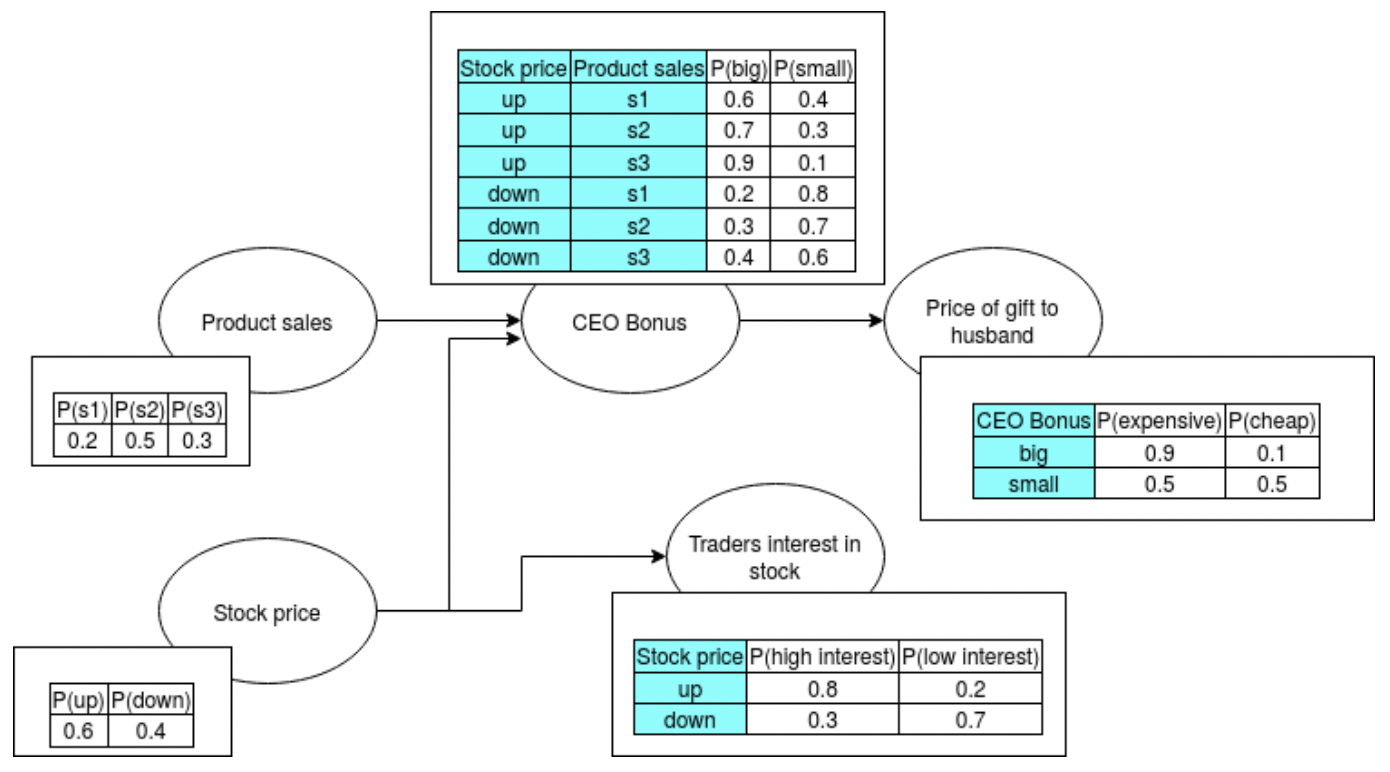

In [1]:
class Node:
    def __init__(self, name: str, data: dict[str, any]) -> None:
        self.name = name
        self.data = data

    def get_all_possible_values(self) -> list[str]:
        """Get all possible values for the node"""
        return list(self.data[0]["prob"].keys())

    def get_probability(self, value: str, condition: dict[str, str] | None = None) -> float:
        """Get the probability of a value given a condition"""
        for case in self.data:
            if case["conditions"] == condition:
                return case["prob"].get(value, 0)
        return 0

    def __lt__(self, other):
        return self.name < other.name

    def __eq__(self, other):
        return self.name == other.name

    def __hash__(self):
        return hash(self.name)


class BayeSianNetwork:
    def __init__(self, parent_to_children: dict[Node, list[Node]]) -> None:
        self.parent_to_children = parent_to_children

        # Compute children to parent
        self.child_to_parents = self._compute_child_to_parents()

    def get_markov_blanket(self, node: Node | str, return_name: bool = False) -> list[Node]:
        """Get the markov blanket of a node"""
        if isinstance(node, str):
            node = self.convert_name_to_node(node)

        # Get parents, children and parents of children
        parents = self.get_parents(node)
        children = self.get_children(node)
        parents_of_children = []
        for child in children:
            parents_of_children += self.get_parents(child)

        # Remove duplicates and return
        related_nodes = parents + children + parents_of_children
        related_nodes = list(set(related_nodes) - set([node]))
        if return_name:
            return [node.name for node in related_nodes]
        else:
            return related_nodes

    def get_parents(self, node: Node | str, return_name: bool = False) -> list[Node]:
        """Get the parents of a node"""
        if isinstance(node, str):
            node = self.convert_name_to_node(node)

        if return_name:
            return [node.name for node in self.child_to_parents.get(node, [])]
        else:
            return self.child_to_parents.get(node, [])

    def get_children(self, node: Node | str, return_name: bool = False) -> list[Node]:
        """Get the children of a node"""
        if isinstance(node, str):
            node = self.convert_name_to_node(node)

        if return_name:
            return [child.name for child in self.parent_to_children.get(node, [])]
        else:
            return self.parent_to_children.get(node, [])

    def convert_name_to_node(self, name: str) -> Node:
        """Convert a name to a node"""
        for node in self.parent_to_children.keys():
            if node.name == name:
                return node
        raise ValueError(f"Node with name {name} not found")

    def get_all_nodes(self, return_name: bool = False) -> list[Node]:
        """Get all nodes in the network"""
        if return_name:
            return [node.name for node in self.parent_to_children.keys()]
        else:
            return sorted(self.parent_to_children.keys())

    def _compute_child_to_parents(self) -> dict[Node, list[Node]]:
        """Compute the child to parent"""
        child_to_parents = {}
        for parent, children in self.parent_to_children.items():
            for child in children:
                if child not in child_to_parents:
                    child_to_parents[child] = []
                child_to_parents[child].append(parent)
        return child_to_parents

In [2]:
product_sales = Node("Product Sales", [{"conditions": None, "prob": {"s1": 0.2, "s2": 0.5, "s3": 0.3}}])
stock_price = Node("Stock Price", [{"conditions": None, "prob": {"up": 0.6, "down": 0.4}}])
trader_stock_interest = Node(
    "Trader Interest In Stock",
    [
        {"conditions": {"Stock Price": "up"}, "prob": {"high interest": 0.8, "low interest": 0.2}},
        {"conditions": {"Stock Price": "down"}, "prob": {"high interest": 0.3, "low interest": 0.7}},
    ],
)
ceo_bonus = Node(
    "CEO bonus",
    [
        {"conditions": {"Stock Price": "up", "Product Sales": "s1"}, "prob": {"big": 0.6, "small": 0.4}},
        {"conditions": {"Stock Price": "up", "Product Sales": "s2"}, "prob": {"big": 0.7, "small": 0.3}},
        {"conditions": {"Stock Price": "up", "Product Sales": "s3"}, "prob": {"big": 0.9, "small": 0.1}},
        {"conditions": {"Stock Price": "down", "Product Sales": "s1"}, "prob": {"big": 0.2, "small": 0.8}},
        {"conditions": {"Stock Price": "down", "Product Sales": "s2"}, "prob": {"big": 0.3, "small": 0.7}},
        {"conditions": {"Stock Price": "down", "Product Sales": "s3"}, "prob": {"big": 0.4, "small": 0.6}},
    ],
)
price_of_gift_to_husband = Node(
    "Price of Gift to Husband",
    [
        {"conditions": {"CEO bonus": "big"}, "prob": {"expensive": 0.9, "cheap": 0.1}},
        {"conditions": {"CEO bonus": "small"}, "prob": {"expensive": 0.5, "cheap": 0.5}},
    ],
)

networks = BayeSianNetwork(
    {
        product_sales: [ceo_bonus],
        stock_price: [trader_stock_interest, ceo_bonus],
        trader_stock_interest: [],
        ceo_bonus: [price_of_gift_to_husband],
        price_of_gift_to_husband: [],
    }
)

# Create MCMC

In [ ]:
import random
from pprint import pprint
from tqdm import tqdm

In [52]:
def markov_chain_monte_carlo(
    network: BayeSianNetwork,
    fix_evidences: dict[str, str] | None = None,
    max_iters: int = 1000,
    disable_tqdm: bool = True,
) -> None:
    """
    Implement the Markov Chain Monte Carlo algorithm: Gibbs Sampling

    :param network: The Bayesian network
    :type network: BayeSianNetwork
    :param fix_evidence: A dictionary of evidence variables and their values to be fixed
    :type fix_evidence: dict[str, str] | None = None
    :param max_iters: The maximum number of iterations
    :type max_iters: int = 1000
    :param verbose: The verbosity level, 0 means no output, 1 means show results, 2 means show results and debug information
    :type verbose: int = 0
    :param disable_tqdm: Whether to disable tqdm
    :type disable_tqdm: bool = True
    """
    # Get list of nodes
    all_nodes = network.get_all_nodes(return_name=True)
    evidence_nodes = list(fix_evidences.keys()) if fix_evidences is not None else []
    non_evidence_nodes = list(set(all_nodes) - set(evidence_nodes))

    # 2. Initialize the state
    ## If a node is not in the evidence, randomly assign a value
    ## If a node is in the evidence, assign the value
    initial_state = {node: None for node in all_nodes}
    if fix_evidences is not None:
        for node, value in fix_evidences.items():
            initial_state[node] = value
    for node in initial_state.keys():
        if initial_state[node] is None:
            initial_state[node] = random.choice(network.convert_name_to_node(node).get_all_possible_values())

    # Run the algorithm
    ## 3. Select order of nodes
    current_node_id = 0
    current_state = initial_state
    state_history = []
    looper = tqdm(range(max_iters), disable=disable_tqdm, desc="Running MCMC")
    for _ in looper:
        # 4. Re sample the value of the current node, given the value from Markov blanket

        ## Compute P(current_node | Markov blanket of current_node)
        ## which is equivalent to P(current_node | parents(current_node)) x product of each P(child | parents(child))
        current_node = network.convert_name_to_node(non_evidence_nodes[current_node_id])
        prob_for_each_value = {}
        for current_node_value in current_node.get_all_possible_values():
            current_state[current_node.name] = current_node_value

            # Current node conditions
            current_node_condition = {}
            for parent in network.get_parents(current_node, return_name=True):
                current_node_condition[parent] = current_state[parent]
            # Compute P(current_node | parents(current_node))
            p_current_node = current_node.get_probability(
                value=current_node_value, condition=current_node_condition or None
            )

            # Compute product of each P(child | parents(child))
            product_p_children = 1
            for child in network.get_children(current_node, return_name=True):
                child_node = network.convert_name_to_node(child)
                parent_of_child = network.get_parents(child, return_name=True)
                child_condition = {}
                for parent in parent_of_child:
                    child_condition[parent] = current_state[parent]
                p_child = child_node.get_probability(value=current_state[child], condition=child_condition)
                product_p_children *= p_child

            # Compute the probability
            prob_for_each_value[current_node_value] = p_current_node * product_p_children

        # Normalize the probabilities
        total_prob = sum(prob_for_each_value.values())
        for key in prob_for_each_value.keys():
            prob_for_each_value[key] /= total_prob

        # Sample the value
        sampled_value = random.choices(
            list(prob_for_each_value.keys()), weights=list(prob_for_each_value.values()), k=1
        )[0]

        # Update the state
        current_state[current_node.name] = sampled_value
        state_history.append(dict(current_state))

        # 5. Go to the next node
        current_node_id = (current_node_id + 1) % len(non_evidence_nodes)

    # Compute the probabilities
    result_prob = {}
    for node in all_nodes:
        result_prob[node] = {}
        for value in network.convert_name_to_node(node).get_all_possible_values():
            result_prob[node][value] = 0
    for state in state_history:
        for node in all_nodes:
            result_prob[node][state[node]] += 1
    for node in all_nodes:
        for value in result_prob[node].keys():
            result_prob[node][value] /= max_iters

    return result_prob


pprint(markov_chain_monte_carlo(networks, max_iters=100000000, disable_tqdm=False))

Running MCMC: 100%|██████████| 100000000/100000000 [07:33<00:00, 220285.76it/s]


{'CEO bonus': {'big': 0.56815112, 'small': 0.43184888},
 'Price of Gift to Husband': {'cheap': 0.2727676, 'expensive': 0.7272324},
 'Product Sales': {'s1': 0.19991049, 's2': 0.499935, 's3': 0.30015451},
 'Stock Price': {'down': 0.40001515, 'up': 0.59998485},
 'Trader Interest In Stock': {'high interest': 0.60004589,
                              'low interest': 0.39995411}}
